In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pytz
import ta

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from datetime import datetime
import MetaTrader5 as mt5

from ortisan_ta.dataaccess import DataItem, MetaTraderDataAccess
import ortisan_ta.utils.analysis as ortisan_ta

from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volume import OnBalanceVolumeIndicator
from ortisan_ta.simulator import MarketSimulator


In [2]:
TOP_50_ASSETS_IBOVESPA = ["ABEV3",
"AZUL4",
"B3SA3",
"BBAS3",
"BBDC4",
"BBSE3",
"BPAC11",
"BRDT3",
"BRFS3",
"BRML3",
"BTOW3",
"CCRO3",
"CIEL3",
"CMIG4",
"COGN3",
"CSNA3",
"CVCB3",
"CYRE3",
"ELET3",
"EQTL3",
"GGBR4",
"GNDI3",
"GOAU4",
"GOLL4",
"IRBR3",
"ITSA4",
"ITUB4",
"JBSS3",
"KLBN11",
"LAME4",
"LREN3",
"MGLU3",
"MRFG3",
"MULT3",
"NTCO3",
"PETR3",
"PETR4",
"PRIO3",
"RADL3",
"RAIL3",
"RENT3",
"SBSP3",
"SULA11",
"SUZB3",
"TOTS3",
"UGPA3",
"USIM5",
"VALE3",
"VVAR3",
"WEGE3"]

### Load data from 1 year

In [6]:
data_access = MetaTraderDataAccess()
dfs = data_access.get_rates_from_symbols(TOP_50_ASSETS_IBOVESPA, datetime(2020, 1, 1), datetime(2021, 1, 1), mt5.TIMEFRAME_D1)
dfs

{'ABEV3':                       Open   High    Low  Close  Spread    Volume
 Date                                                             
 2020-01-01 21:00:00  18.45  18.83  18.37  18.78       1  16411300
 2020-01-02 21:00:00  18.54  18.74  18.48  18.52       1  20059000
 2020-01-05 21:00:00  18.45  18.75  18.28  18.60       1  14644300
 2020-01-06 21:00:00  18.63  18.81  18.45  18.64       1  18036600
 2020-01-07 21:00:00  18.67  18.74  18.45  18.55       1  14051700
 ...                    ...    ...    ...    ...     ...       ...
 2020-12-21 21:00:00  15.50  15.75  15.47  15.51       1  15406100
 2020-12-22 21:00:00  15.58  15.73  15.50  15.50       1  11560800
 2020-12-27 21:00:00  15.57  15.94  15.50  15.77       1  11958000
 2020-12-28 21:00:00  15.90  16.01  15.78  15.95       1  13638800
 2020-12-29 21:00:00  16.05  16.10  15.65  15.65       1  19432700
 
 [249 rows x 6 columns],
 'AZUL4':                       Open   High    Low  Close  Spread    Volume
 Date            

### Calculate return and variance of return we will use then into cluster calculations

In [9]:
dict_closes = {symbol: df.Close for (symbol, df) in dfs.items()}
df_closes = pd.DataFrame.from_dict(dict_closes, orient='columns')
df_closes.head()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC4,BBSE3,BPAC11,BRDT3,BRFS3,BRML3,...,RENT3,SBSP3,SULA11,SUZB3,TOTS3,UGPA3,USIM5,VALE3,VVAR3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 21:00:00,18.78,58.80,43.56,52.53,33.30,33.82,74.89,29.57,35.88,18.22,...,49.30,58.87,58.47,40.79,22.88,25.28,9.61,53.07,11.73,34.97
2020-01-02 21:00:00,18.52,56.76,42.30,52.44,33.32,33.44,74.94,29.40,35.94,18.63,...,48.59,57.86,60.84,40.65,23.36,24.98,9.51,52.68,11.48,34.53
2020-01-05 21:00:00,18.60,55.00,41.90,51.74,32.72,33.99,74.06,27.93,35.57,18.50,...,48.02,56.97,60.43,40.58,22.83,24.44,9.33,52.36,11.48,34.62
2020-01-06 21:00:00,18.64,56.82,43.25,51.35,32.15,34.01,74.82,27.89,35.16,18.80,...,48.49,56.00,59.62,41.10,22.93,24.98,9.42,52.74,11.65,34.88
2020-01-07 21:00:00,18.55,56.92,43.14,50.89,31.65,33.99,74.33,27.76,36.51,18.25,...,48.25,55.17,59.41,43.15,22.62,24.79,9.30,52.75,11.60,33.56


In [55]:
df_daily_returns = df_closes/df_closes.shift(1) -1

df_return_means_year = df_daily_returns.resample('Y').mean()
df_return_std_year = df_daily_returns.resample('Y').std()

df_return_means_year = df_return_means_year.T
df_return_std_year = df_return_std_year.T

adb = pd.concat([df_return_means_year, df_return_std_year], axis=1, join="inner")
adb.columns = ["MY", "SY"]
adb

,MY,SY
ABEV3,-0.000304,0.029209
AZUL4,0.000990,0.070455
B3SA3,0.002021,0.035635
BBAS3,-0.000457,0.039039
BBDC4,-0.000184,0.035974
BBSE3,-0.000203,0.025685
BPAC11,0.002139,0.049887
BRDT3,-0.000459,0.037647
BRFS3,-0.001201,0.038825
BRML3,-0.001482,0.043765


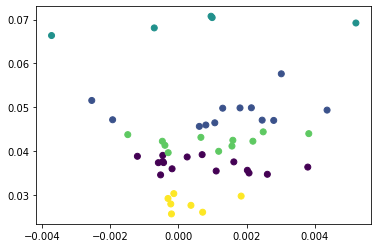

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=24, max_iter = 300)
pred_y = kmeans.fit_predict(adb)
plt.scatter(adb['MY'], adb["SY"], c = pred_y) #posicionamento dos eixos x e y

In [58]:
adb['Cluster'] = pred_y
adb.sort_values(by=['Cluster'])

,MY,SY,Cluster
WEGE3,0.003791,0.036364,0
RAIL3,-0.000587,0.037368,0
SBSP3,-0.000434,0.037389,0
SULA11,-0.000520,0.034582,0
SUZB3,0.002071,0.035012,0
LAME4,0.000696,0.039202,0
TOTS3,0.001625,0.037548,0
BRFS3,-0.001201,0.038825,0
CMIG4,0.001108,0.035473,0
JBSS3,0.000257,0.038671,0


### Join all closes into one dataframe. Each column is the symbol

In [7]:
dict_closes = {symbol: df.Close for (symbol, df) in dfs.items()}
df_closes = pd.DataFrame.from_dict(dict_closes, orient='columns')
df_closes.head()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC4,BBSE3,BPAC11,BRDT3,BRFS3,BRML3,...,RENT3,SBSP3,SULA11,SUZB3,TOTS3,UGPA3,USIM5,VALE3,VVAR3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 21:00:00,18.78,58.80,43.56,52.53,33.30,33.82,74.89,29.57,35.88,18.22,...,49.30,58.87,58.47,40.79,22.88,25.28,9.61,53.07,11.73,34.97
2020-01-02 21:00:00,18.52,56.76,42.30,52.44,33.32,33.44,74.94,29.40,35.94,18.63,...,48.59,57.86,60.84,40.65,23.36,24.98,9.51,52.68,11.48,34.53
2020-01-05 21:00:00,18.60,55.00,41.90,51.74,32.72,33.99,74.06,27.93,35.57,18.50,...,48.02,56.97,60.43,40.58,22.83,24.44,9.33,52.36,11.48,34.62
2020-01-06 21:00:00,18.64,56.82,43.25,51.35,32.15,34.01,74.82,27.89,35.16,18.80,...,48.49,56.00,59.62,41.10,22.93,24.98,9.42,52.74,11.65,34.88
2020-01-07 21:00:00,18.55,56.92,43.14,50.89,31.65,33.99,74.33,27.76,36.51,18.25,...,48.25,55.17,59.41,43.15,22.62,24.79,9.30,52.75,11.60,33.56


### Calculate correlation between all symbols

In [ ]:
corr = df_closes.corr()

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_lowest_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Lowest Absolute Correlations")
print(get_lowest_abs_correlations(corr, 5))